0. 导入库函数与数据预处理

In [13]:
# 1. 导入所需库
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings('ignore')

from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import scipy.sparse
import seaborn as sns

from scipy.stats import spearmanr

# 展示高清图 
from matplotlib_inline import backend_inline 
backend_inline.set_matplotlib_formats('svg') 

print("所有库已成功导入！")

所有库已成功导入！


In [14]:
# 加载数据
df = pd.read_csv('alldata.csv')

# 查看数据基本信息
print("数据集基本信息：")
print(f"数据形状: {df.shape}")
print(f"学科数量: {df['subject_name'].nunique()}")

# 缺失值处理
print(f"缺失值统计：",df.isnull().sum())
df = df.dropna()
df.reset_index(drop=True, inplace=True)  # 重置索引，避免后续索引不匹配
print("\n缺失值处理后数据形状: ", df.shape)

数据集基本信息：
数据形状: (34121, 9)
学科数量: 22
缺失值统计： id                             0
subject_name                   0
institution_name               0
country_region              3161
world_rank                     0
web_of_science_documents       0
cites                          0
cites_per_paper                0
top_papers                     0
dtype: int64

缺失值处理后数据形状:  (30960, 9)


In [ ]:
# 固定随机种子以便复现
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 目标变量
raw_y = df['world_rank'].values.astype(float)

# 数值特征
num_features = ["web_of_science_documents", "cites", "cites_per_paper", "top_papers"]
X_num = df[num_features].values.astype(float)

# 类别特征
cat_features = ["subject_name", "institution_name", "country_region"]

# 类别编码
encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
X_cat = df[cat_features].values.astype(int)


# 为TabNet准备数据格式
# 合并数值和类别特征
all_features = num_features + cat_features
X_all = np.column_stack([X_num, X_cat])

# 确定类别特征的索引位置（在合并后的特征矩阵中）
cat_idxs = list(range(len(num_features), len(num_features) + len(cat_features)))
# 获取类别特征的维度
cat_dims = [int(df[col].nunique()) for col in cat_features]

print(f"特征总数: {len(all_features)}")
print(f"数值特征: {num_features}")
print(f"类别特征: {cat_features}")
print(f"类别特征索引: {cat_idxs}")
print(f"类别特征维度: {cat_dims}")

# 重新划分数据（保持与之前相同的划分）
X_train_tabnet, X_temp_tabnet, y_train_tabnet, y_temp_tabnet = train_test_split(
    X_all, raw_y, test_size=0.4, random_state=seed,shuffle=True
)
X_val_tabnet, X_test_tabnet, y_val_tabnet, y_test_tabnet = train_test_split(
    X_temp_tabnet, y_temp_tabnet, test_size=0.5, random_state=seed,shuffle=True
)

print(f"训练集形状: {X_train_tabnet.shape}")
print(f"验证集形状: {X_val_tabnet.shape}")
print(f"测试集形状: {X_test_tabnet.shape}")

# 对数值特征进行标准化（只对数值部分）
X_train_tabnet_scaled = X_train_tabnet.copy()
X_val_tabnet_scaled = X_val_tabnet.copy()
X_test_tabnet_scaled = X_test_tabnet.copy()

# 只标准化数值特征部分
scaler_X = StandardScaler()
X_train_tabnet_scaled[:, :len(num_features)] = scaler_X.fit_transform(X_train_tabnet[:, :len(num_features)])
X_val_tabnet_scaled[:, :len(num_features)] = scaler_X.transform(X_val_tabnet[:, :len(num_features)])
X_test_tabnet_scaled[:, :len(num_features)] = scaler_X.transform(X_test_tabnet[:, :len(num_features)])

#! 目标变量缩放：将 world_rank 缩放到 [0,1] 区间（可选）
y_train_tabnet_scaled = np.log(y_train_tabnet)
y_val_tabnet_scaled = np.log(y_val_tabnet).reshape(-1, 1)
y_test_tabnet_scaled = np.log(y_test_tabnet).reshape(-1, 1)

#! 增强采样：对高排名（难预测）样本进行过采样
# 创建增强版训练集：复制高排名样本
RANK_THRESHOLD = 3000  # 排名>2500的样本（排名靠后，难预测）

# 找出高排名样本索引
high_rank_indices = np.where(y_train_tabnet >= RANK_THRESHOLD)[0]

# 构造新的训练数据（重复高排名样本）
repeat_times = 3  # 重复3次平衡数据
X_aug = np.vstack([
    X_train_tabnet_scaled,
    np.repeat(X_train_tabnet_scaled[high_rank_indices], repeat_times, axis=0)
])
y_aug = np.concatenate([
    y_train_tabnet_scaled.flatten(),
    np.repeat(y_train_tabnet_scaled[high_rank_indices], repeat_times)
])

print(f"原始训练样本数: {len(X_train_tabnet_scaled)}")
print(f"高排名样本数: {len(high_rank_indices)}")
print(f"增强后样本数: {len(X_aug)}")

print("✔️ 数据预处理完成！\n")

使用设备: cpu
特征总数: 7
数值特征: ['web_of_science_documents', 'cites', 'cites_per_paper', 'top_papers']
类别特征: ['subject_name', 'institution_name', 'country_region']
类别特征索引: [4, 5, 6]
类别特征维度: [22, 7334, 138]
训练集形状: (18576, 7)
验证集形状: (6192, 7)
测试集形状: (6192, 7)
原始训练样本数: 18576
高排名样本数: 1067
增强后样本数: 21777
✔️ 数据预处理完成！



### TabNet自监督预训练

TabNet的一个重要特性是可以先进行无监督预训练，让模型学习特征之间的内在关系，为后续的有监督训练提供更好的初始化。

In [26]:
# TabNet预训练器配置（稳定版）
pretrainer = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,  # 嵌入维度
    n_d=32,  # 决策维度
    n_a=32,  # 注意力维度
    n_steps=3,  # 步骤数
    gamma=1.5,  # 特征重用系数
    n_independent=2,  # 独立层
    n_shared=2,  # 共享层
    epsilon=1e-15,
    momentum=0.98,
    mask_type='entmax',  # 掩码类型
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=1e-3, weight_decay=1e-5),  # 降低学习率和正则化
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode='min', patience=5, factor=0.5),  # 增加patience
    verbose=1,
)

print("开始自监督预训练...")

# 进行预训练
pretrainer.fit(
    # X_train=X_train_tabnet_scaled,
    X_train=X_aug,
    eval_set=[X_val_tabnet_scaled],
    max_epochs=50,  # 减少轮数，避免过拟合
    patience=10,  # 增加耐心值
    batch_size=512,  # 增大batch size提高稳定性
    virtual_batch_size=128,
    num_workers=0,
    drop_last=True,
    pretraining_ratio=0.6,  # 降低掩码比例，减少任务难度
)

print("预训练完成！")

开始自监督预训练...
epoch 0  | loss: 7.06433 | val_0_unsup_loss_numpy: 49.591880798339844|  0:00:08s
epoch 0  | loss: 7.06433 | val_0_unsup_loss_numpy: 49.591880798339844|  0:00:08s
epoch 1  | loss: 3.79783 | val_0_unsup_loss_numpy: 7.068689823150635|  0:00:20s
epoch 1  | loss: 3.79783 | val_0_unsup_loss_numpy: 7.068689823150635|  0:00:20s
epoch 2  | loss: 2.69829 | val_0_unsup_loss_numpy: 5.721879959106445|  0:00:30s
epoch 2  | loss: 2.69829 | val_0_unsup_loss_numpy: 5.721879959106445|  0:00:30s
epoch 3  | loss: 2.13828 | val_0_unsup_loss_numpy: 5.538290023803711|  0:00:44s
epoch 3  | loss: 2.13828 | val_0_unsup_loss_numpy: 5.538290023803711|  0:00:44s
epoch 4  | loss: 1.69705 | val_0_unsup_loss_numpy: 6.306300163269043|  0:00:57s
epoch 4  | loss: 1.69705 | val_0_unsup_loss_numpy: 6.306300163269043|  0:00:57s
epoch 5  | loss: 1.43342 | val_0_unsup_loss_numpy: 5.219570159912109|  0:01:10s
epoch 5  | loss: 1.43342 | val_0_unsup_loss_numpy: 5.219570159912109|  0:01:10s
epoch 6  | loss: 1.22423 |

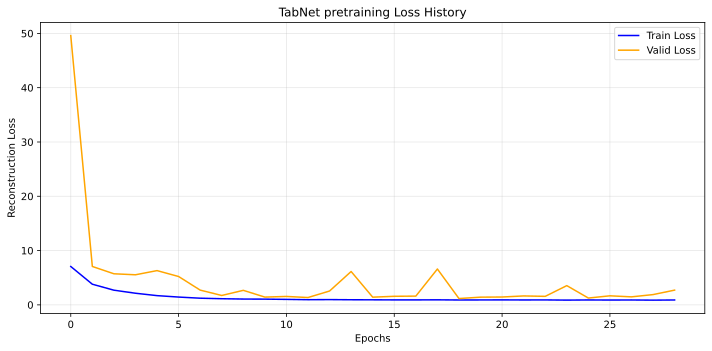

预训练损失曲线已绘制。


In [29]:
# 绘制预训练损失曲线
hist = pretrainer.history


plt.figure(figsize=(10, 5))
plt.plot(hist['loss'], label='Train Loss', color='blue')

plt.plot(hist['val_0_unsup_loss_numpy'], label='Valid Loss', color='orange')

plt.title('TabNet pretraining Loss History')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("预训练损失曲线已绘制。")

### TabNet有监督训练

使用预训练的权重初始化TabNet回归器，然后在排名预测任务上进行有监督训练。

In [ ]:
# 构建回归器（与预训练器架构保持一致）
regressor = TabNetRegressor(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,  
    n_d=32,  
    n_a=32, 
    n_steps=3,  
    gamma=1.5,  
    n_independent=2, 
    n_shared=2, 
    lambda_sparse=1e-3,  # 适度稀疏惩罚
    optimizer_fn=torch.optim.AdamW,
    optimizer_params={'lr': 1e-3, 'weight_decay': 1e-5},  
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params={
        'mode': 'min',
        'factor': 0.8,
        'patience': 10,  # 与预训练器一致
        'verbose': True
    },
    mask_type='entmax',
    device_name=device,
    verbose=1
)

# 使用预训练模型初始化权重 + 数据增强
regressor.fit(
    X_train=X_aug,  # 使用增强数据
    y_train=y_aug.reshape(-1, 1),
    eval_set=[(X_val_tabnet_scaled, y_val_tabnet_scaled)], 
    max_epochs=60,  # 训练轮数
    patience=10,  # 耐心值
    batch_size=256, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=True,
    # from_unsupervised=pretrainer  #! 是否使用预训练权重初始化 即是否利用预训练的结果(可选)
)

print("✅ 有监督微调完成！\n")

epoch 0  | loss: 23.02422| val_0_mse: 4.37239 |  0:00:07s
epoch 1  | loss: 1.00764 | val_0_mse: 0.54452 |  0:00:14s
epoch 2  | loss: 0.48773 | val_0_mse: 0.35056 |  0:00:22s
epoch 3  | loss: 0.37401 | val_0_mse: 0.29516 |  0:00:30s
epoch 4  | loss: 0.28211 | val_0_mse: 0.24284 |  0:00:37s
epoch 5  | loss: 0.23107 | val_0_mse: 0.22219 |  0:00:44s
epoch 6  | loss: 0.20657 | val_0_mse: 0.24381 |  0:00:50s
epoch 7  | loss: 0.18385 | val_0_mse: 0.16768 |  0:00:57s
epoch 8  | loss: 0.17015 | val_0_mse: 0.15675 |  0:01:04s
epoch 9  | loss: 0.1403  | val_0_mse: 0.14277 |  0:01:11s
epoch 10 | loss: 0.13303 | val_0_mse: 0.13416 |  0:01:18s
epoch 11 | loss: 0.1223  | val_0_mse: 0.1711  |  0:01:25s
epoch 12 | loss: 0.11968 | val_0_mse: 0.18891 |  0:01:33s
epoch 13 | loss: 0.10897 | val_0_mse: 0.19073 |  0:01:40s
epoch 14 | loss: 0.1048  | val_0_mse: 0.12702 |  0:01:47s
epoch 15 | loss: 0.09797 | val_0_mse: 0.1342  |  0:01:53s
epoch 16 | loss: 0.0978  | val_0_mse: 0.17553 |  0:02:00s
epoch 17 | los

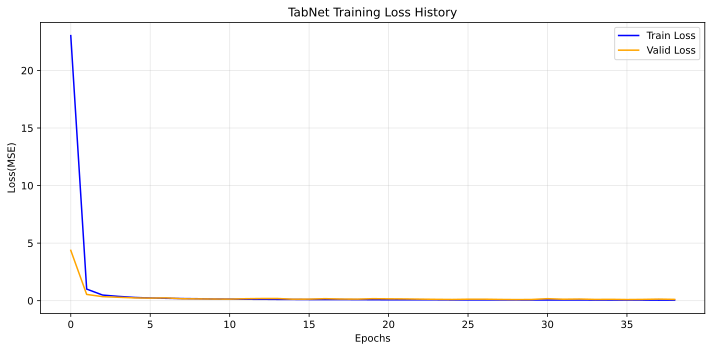

In [23]:
# 可视化有监督微调的训练历史
hist = regressor.history

plt.figure(figsize=(10, 5))
plt.plot(hist['loss'], label='Train Loss', color='blue')
plt.plot(hist['val_0_mse'], label='Valid Loss', color='orange')
plt.title('TabNet Training Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss(MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 模型评估与保存

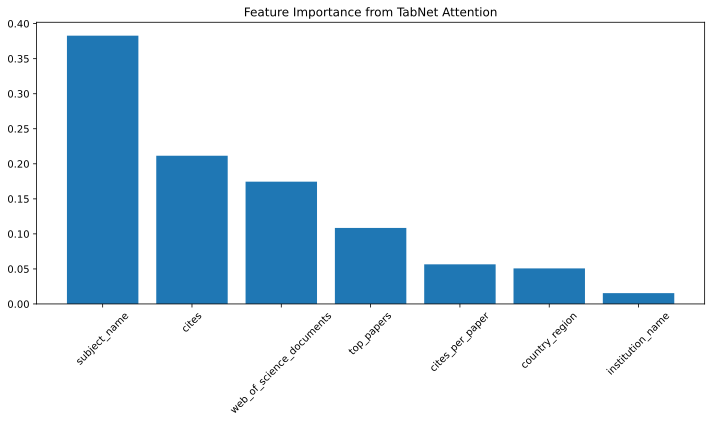

In [24]:
# 获取特征重要性（基于注意力）
feat_importance = regressor.feature_importances_
plt.figure(figsize=(10, 6))
indices = np.argsort(feat_importance)[::-1]
plt.bar(range(len(feat_importance)), feat_importance[indices])
plt.xticks(range(len(feat_importance)), [all_features[i] for i in indices], rotation=45)
plt.title("Feature Importance from TabNet Attention")
plt.tight_layout()
plt.show()

🧪 在测试集上评估模型性能
✅ 测试集性能:
   MAE: 259.79
   RMSE:  488.82
   spearman:   0.98
✅ 测试集性能:
   MAE: 259.79
   RMSE:  488.82
   spearman:   0.98


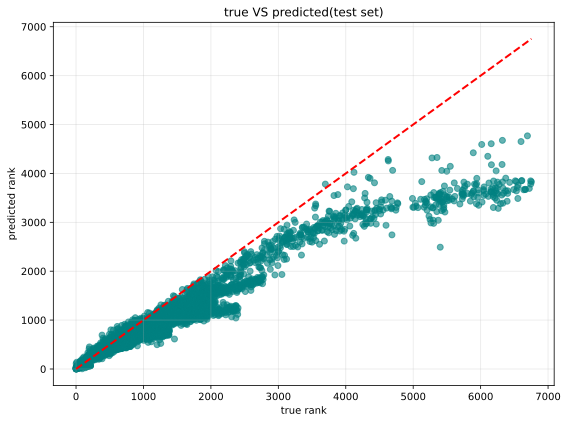

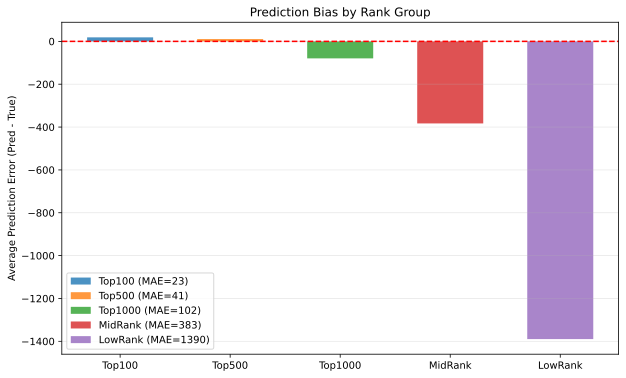

In [ ]:
print("="*60)
print("🧪 在测试集上评估模型性能")
print("="*60)

y_pred_scaled = regressor.predict(X_test_tabnet_scaled)

# log 的逆变换是 exp
y_pred = np.exp(y_pred_scaled).flatten()  # 还原 log1p 变换
y_true = y_test_tabnet.reshape(-1)

# 计算指标
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
spearman_corr, _ = spearmanr(y_pred, y_true)

print(f"✅ 测试集性能:")
print(f"   MAE: {mae:.2f}")
print(f"   RMSE:  {rmse:.2f}")
print(f"   spearman:   {spearman_corr:.2f}")

# 可视化真实 vs 预测
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.6, color='teal')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('true rank')
plt.ylabel('predicted rank')
plt.title('true VS predicted(test set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

bins = [0, 100, 500, 1000, 3000, 7000]
labels = ['Top100', 'Top500', 'Top1000', 'MidRank', 'LowRank']
df_eval = pd.DataFrame({'true': y_true, 'pred': y_pred})
df_eval['group'] = pd.cut(df_eval['true'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
for name, group in df_eval.groupby('group'):
    mae = mean_absolute_error(group['true'], group['pred'])
    bias = (group['pred'] - group['true']).mean()
    plt.bar(name, bias, label=f"{name} (MAE={mae:.0f})", alpha=0.8, width=0.6)

plt.axhline(0, color='red', linestyle='--')
plt.title("Prediction Bias by Rank Group")
plt.ylabel("Average Prediction Error (Pred - True)")
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.show()

根据以上结果可以看出主要是低排名（排名数较高）的预测不佳

## 保存模型

In [ ]:
# 保存模型
torch.save(regressor, 'tabnet.pth')  # 只保存模型参数